In [ ]:
%pip install -r requirements.txt

In [71]:
from statsbombpy import sb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen



### Usefull Functions

In [70]:
competitions = sb.competitions()
filtered_competitions = competitions[(competitions['competition_id'] == 43) & (competitions['season_name'] == '2022')]
matches = sb.matches(competition_id=43, season_id=filtered_competitions['season_id'].values[0])

match_data = matches[matches['match_id'] == 3857300]
events = sb.events(match_id=3857300)
lineups = sb.lineups(match_id=3857300)

events = events[~events['type'].isin(['Starting XI', 'Half Start'])]


In [59]:
def classify_coordinate(coordinate):
    if isinstance(coordinate, list) and len(coordinate) == 2:  # Ensure the value is a list of two elements
        x, y = coordinate
        
        # First row of the grid (y <= 26.67)
        if y <= 26.67:
            if x <= 40:
                return 1
            elif x <= 80:
                return 2
            else:
                return 3
                
        # Second row of the grid (26.67 < y <= 53.33)
        elif y <= 53.33:
            if x <= 40:
                return 4
            elif x <= 80:
                return 5
            else:
                return 6
                
        # Third row of the grid (y > 53.33)
        else:
            if x <= 40:
                return 7
            elif x <= 80:
                return 8
            else:
                return 9
    else:
        return None

def normalize_direction(coordinate):
    max_x = 120
    max_y = 80
    if isinstance(coordinate, list) and len(coordinate) == 2:  # Ensure the value is a list of two elements
        x, y = coordinate

        return [max_x - x, max_y - y]
    else:
        return None



In [ ]:
def plot_per_thirds(counts):
    # Initialize the pitch (120x80)
    pitch = Pitch(pitch_type='statsbomb', pitch_length=120, pitch_width=80, line_color='black')

    # Create the figure
    fig, ax = pitch.draw(figsize=(10, 6))

    # Define the regions as polygons or rectangles
    regions = {
        1: {'xy': (0, 53.33), 'width': 40, 'height': 26.67},   # Top-left
        2: {'xy': (0, 26.67), 'width': 40, 'height': 26.67},   # Middle-left
        3: {'xy': (0, 0), 'width': 40, 'height': 26.67},       # Bottom-left
        
        4: {'xy': (40, 53.33), 'width': 40, 'height': 26.67},  # Top-center
        5: {'xy': (40, 26.67), 'width': 40, 'height': 26.67},  # Middle-center
        6: {'xy': (40, 0), 'width': 40, 'height': 26.67},      # Bottom-center
        
        7: {'xy': (80, 53.33), 'width': 40, 'height': 26.67},  # Top-right
        8: {'xy': (80, 26.67), 'width': 40, 'height': 26.67},  # Middle-right
        9: {'xy': (80, 0), 'width': 40, 'height': 26.67}       # Bottom-right
    }


    # Plot each region with the counts
    for i, region in regions.items():
        # Plot the rectangle for each region
        ax.add_patch(plt.Rectangle(**region, fill=True, color='lightblue', alpha=0.3, edgecolor='black'))
        
        # Add text for the classification and counts
        center_x = region['xy'][0] + region['width'] / 2
        center_y = region['xy'][1] + region['height'] / 2
        
        count = counts.get(i, 0)  # Get the count, defaulting to 0 if the region has no points
        
        ax.text(center_x, center_y, f'Region {i}\n{count} touches', color='black',
                ha='center', va='center', fontsize=12, weight='bold')
        
    ax.invert_yaxis()

    # Show the plot
    return plt.show()


In [5]:
commons = ["id",
    "index",
    "period", 
    "timestamp",
    "minute",
    "second",
    "type",
    "possession",
    "possession_team",
    "play_pattern",
    "team",
    "player",
    "position",
    "location",
    "duration",
    "under_pressure",
    "out"
]

columns = events.columns


In [6]:
ball_columns =  commons + [col for col in columns if col.startswith('ball')]
block_columns =  commons + [col for col in columns if col.startswith('block')]
carry_columns =  commons + [col for col in columns if col.startswith('carry')]
clearance_columns =  commons + [col for col in columns if col.startswith('clearance')]
dribble_columns =  commons + [col for col in columns if col.startswith('dribble')]
duel_columns =  commons + [col for col in columns if col.startswith('duel')]
foul_columns =  commons + [col for col in columns if col.startswith('foul')]
goalkeeper_columns =  commons + [col for col in columns if col.startswith('goalkeeper')]
pass_columns = commons + [col for col in columns if col.startswith('pass')]
shot_columns =  commons + [col for col in columns if col.startswith('shot')]
substitution_columns =  commons + [col for col in columns if col.startswith('substitution')]


Primeiro passe da Arabia Saudita foi para a coordenada [44.8, 41.9], o que significa que eles atacaram da esquerda para direita no 1 tempo

In [67]:
first_pass = events[events['type'] == 'Pass'].head(1)
print(first_pass["pass_end_location"])

6    [44.8, 41.9]
Name: pass_end_location, dtype: object


Normalizando ações de jogo, para que todas acões sejam contabilizadas da esquerda para direita

In [62]:
events.loc[(events['team'] == 'Argentina') & (events['period'] == 1), 'location'] = events.loc[(events['team'] == 'Argentina') & (events['period'] == 1), 'location'].apply(normalize_direction)
events.loc[(events['team'] == 'Saudi Arabia') & (events['period'] == 2), 'location'] = events.loc[(events['team'] == 'Arabia') & (events['period'] == 2), 'location'].apply(normalize_direction)
events['field_third'] = events['location'].apply(classify_coordinate)

In [64]:
argentina = events[events['team'] == 'Argentina']

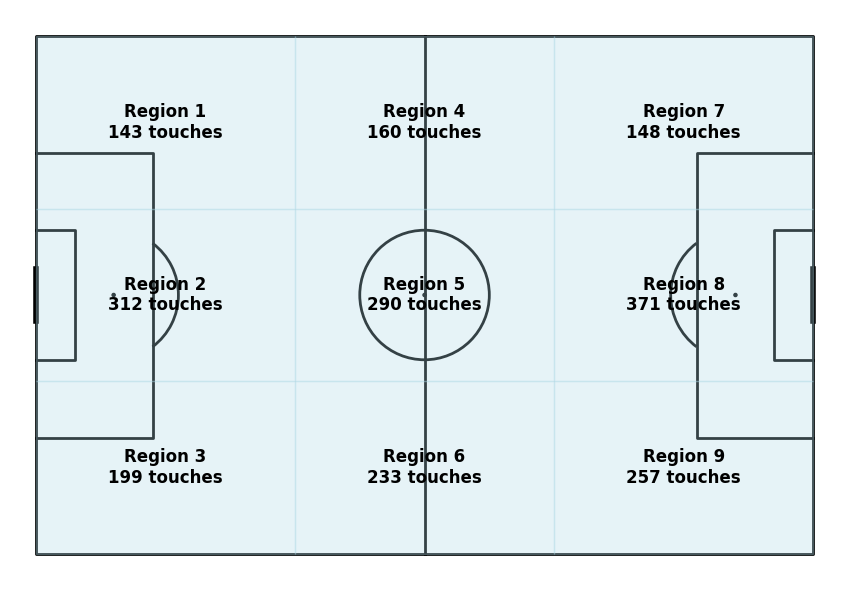

In [65]:
counts = argentina['field_third'].value_counts().to_dict()

plot_per_thirds(counts)

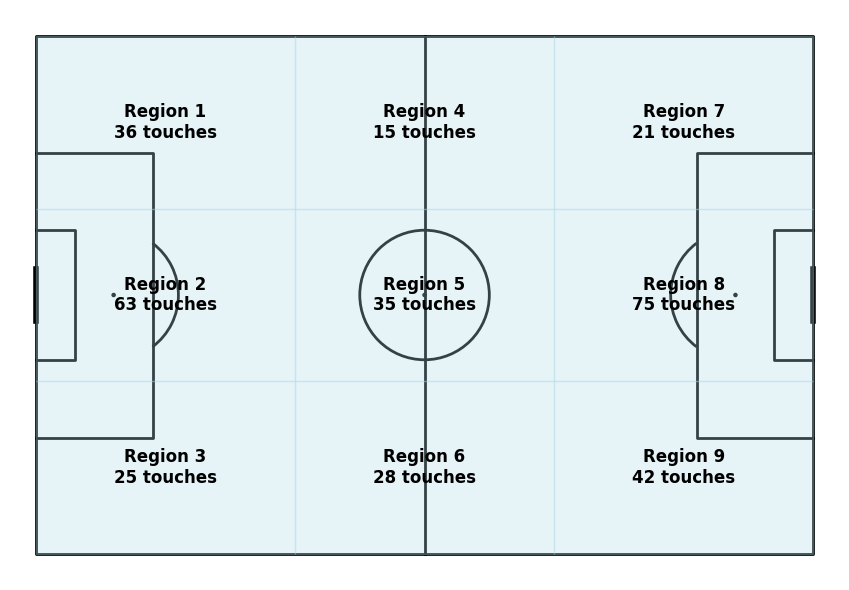

In [66]:
counts = argentina[argentina['under_pressure'] == True]['field_third'].value_counts().to_dict()

plot_per_thirds(counts)

In [106]:
import pandas as pd
import numpy as np

from mplsoccer import Pitch, Sbopen
from mplsoccer import VerticalPitch,Pitch

In [107]:
parser = Sbopen()
df, related, freeze, tactics = parser.event(3857300)

In [136]:
df

,x,y,end_x,end_y,player_name,pass_recipient_name,team_name,minute,player_id
4,61.0,40.1,44.8,41.9,Saleh Khalid Al Shehri,Mohammed Kanoo,Saudi Arabia,0,51469.0
7,46.6,41.9,58.5,40.6,Mohammed Kanoo,Saleh Khalid Al Shehri,Saudi Arabia,0,5713.0
10,57.6,41.0,47.0,41.9,Saleh Khalid Al Shehri,Mohammed Kanoo,Saudi Arabia,0,51469.0
13,48.4,48.2,45.5,72.6,Mohammed Kanoo,Hassan Mohammed Al-Tambakti,Saudi Arabia,0,5713.0
16,52.5,72.6,87.0,73.3,Hassan Mohammed Al-Tambakti,Salman Mohammed Al Faraj,Saudi Arabia,0,51546.0
...,...,...,...,...,...,...,...,...,...
3313,95.0,70.5,97.8,71.0,Lionel Andrés Messi Cuccittini,Ángel Fabián Di María Hernández,Argentina,103,5503.0
3317,45.2,58.3,27.2,44.4,Lisandro Martínez,Damián Emiliano Martínez,Argentina,103,27768.0
3320,32.6,46.8,53.7,24.1,Damián Emiliano Martínez,Enzo Fernandez,Argentina,103,6909.0
3323,53.3,26.3,56.7,56.6,Enzo Fernandez,Lisandro Martínez,Argentina,103,38718.0


In [108]:
df = df[df.type_name == 'Pass']
df = df[['x', 'y', 'end_x', 'end_y', "player_name", "pass_recipient_name","team_name","minute",'player_id']]
tactics = tactics[['jersey_number','player_id']]

# Merge tactics and df on player_id
df_merged = pd.merge(df, tactics[['jersey_number', 'player_id']], on='player_id', how='left')

In [116]:
df_merged

,x,y,end_x,end_y,player_name,pass_recipient_name,team_name,minute,player_id,jersey_number
0,61.0,40.1,44.8,41.9,Saleh Khalid Al Shehri,Mohammed Kanoo,Saudi Arabia,0,51469.0,11.0
1,61.0,40.1,44.8,41.9,Saleh Khalid Al Shehri,Mohammed Kanoo,Saudi Arabia,0,51469.0,11.0
2,46.6,41.9,58.5,40.6,Mohammed Kanoo,Saleh Khalid Al Shehri,Saudi Arabia,0,5713.0,23.0
3,46.6,41.9,58.5,40.6,Mohammed Kanoo,Saleh Khalid Al Shehri,Saudi Arabia,0,5713.0,23.0
4,46.6,41.9,58.5,40.6,Mohammed Kanoo,Saleh Khalid Al Shehri,Saudi Arabia,0,5713.0,23.0
...,...,...,...,...,...,...,...,...,...,...
2065,45.2,58.3,27.2,44.4,Lisandro Martínez,Damián Emiliano Martínez,Argentina,103,27768.0,25.0
2066,32.6,46.8,53.7,24.1,Damián Emiliano Martínez,Enzo Fernandez,Argentina,103,6909.0,23.0
2067,32.6,46.8,53.7,24.1,Damián Emiliano Martínez,Enzo Fernandez,Argentina,103,6909.0,23.0
2068,53.3,26.3,56.7,56.6,Enzo Fernandez,Lisandro Martínez,Argentina,103,38718.0,24.0


In [109]:
hteam = df_merged['team_name'].iloc[0]
ateam = df_merged['team_name'].iloc[-1]
print('Home Team : ' + hteam)
print('Away Team : ' + ateam)

Home Team : Saudi Arabia
Away Team : Argentina


In [123]:
df_home_pass = df_merged[df_merged.team_name == ateam]

# Check player play time
home_player_df = df_merged[df_merged.team_name == ateam].groupby('player_name').agg({'minute': [min, max]}).reset_index()
home_player_df = pd.concat([home_player_df['player_name'], home_player_df['minute']], axis=1)
home_player_df['minutes_played'] = home_player_df['max'] - home_player_df['min']
home_player_df = home_player_df.sort_values('minutes_played', ascending=False)

C:\Users\Tobi\AppData\Local\Temp\ipykernel_14576\2779473072.py:4: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  home_player_df = df_merged[df_merged.team_name == ateam].groupby('player_name').agg({'minute': [min, max]}).reset_index()
C:\Users\Tobi\AppData\Local\Temp\ipykernel_14576\2779473072.py:4: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  home_player_df = df_merged[df_merged.team_name == ateam].groupby('player_name').agg({'minute': [min, max]}).reset_index()


In [124]:
df_home_pass

,x,y,end_x,end_y,player_name,pass_recipient_name,team_name,minute,player_id,jersey_number
16,34.9,4.4,48.9,8.4,Nicolás Alejandro Tagliafico,Lautaro Javier Martínez,Argentina,0,5507.0,3.0
17,34.9,4.4,48.9,8.4,Nicolás Alejandro Tagliafico,Lautaro Javier Martínez,Argentina,0,5507.0,3.0
18,45.3,5.3,34.3,9.8,Lautaro Javier Martínez,Leandro Daniel Paredes,Argentina,0,11456.0,22.0
19,45.3,5.3,34.3,9.8,Lautaro Javier Martínez,Leandro Daniel Paredes,Argentina,0,11456.0,22.0
20,33.8,10.0,19.8,10.9,Leandro Daniel Paredes,Nicolás Hernán Otamendi,Argentina,0,16308.0,5.0
...,...,...,...,...,...,...,...,...,...,...
2065,45.2,58.3,27.2,44.4,Lisandro Martínez,Damián Emiliano Martínez,Argentina,103,27768.0,25.0
2066,32.6,46.8,53.7,24.1,Damián Emiliano Martínez,Enzo Fernandez,Argentina,103,6909.0,23.0
2067,32.6,46.8,53.7,24.1,Damián Emiliano Martínez,Enzo Fernandez,Argentina,103,6909.0,23.0
2068,53.3,26.3,56.7,56.6,Enzo Fernandez,Lisandro Martínez,Argentina,103,38718.0,24.0


In [125]:
home_player_name = home_player_df.player_name[:11].tolist()
df_home_pass = df_home_pass[df_home_pass.player_name.isin(home_player_name)]
df_home_pass = df_home_pass[df_home_pass.pass_recipient_name.isin(home_player_name)]

In [126]:
home_player_name

['Damián Emiliano Martínez',
 'Rodrigo Javier De Paul',
 'Nahuel Molina Lucero',
 'Nicolás Hernán Otamendi',
 'Ángel Fabián Di María Hernández',
 'Lautaro Javier Martínez',
 'Lionel Andrés Messi Cuccittini',
 'Nicolás Alejandro Tagliafico',
 'Cristian Gabriel Romero',
 'Leandro Daniel Paredes',
 'Lisandro Martínez']

In [127]:
scatter_df = pd.DataFrame()
for i, name in enumerate(df_home_pass["player_name"].unique()):
    passx = df_home_pass.loc[df_home_pass["player_name"] == name]["x"].to_numpy()
    recx = df_home_pass.loc[df_home_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = df_home_pass.loc[df_home_pass["player_name"] == name]["y"].to_numpy()
    recy = df_home_pass.loc[df_home_pass["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name

    #make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))

    #calculate number of passes
    scatter_df.at[i, "no"] = df_home_pass.loc[df_home_pass["player_name"] == name].count().iloc[0]
    scatter_df.at[i, "jersey_number"] = df_home_pass.loc[df_home_pass["player_name"] == name]['jersey_number'].iloc[0]
    scatter_df['jersey_number'] = scatter_df['jersey_number'].astype(int)
    
#adjust the size of a circle so that the player who made more passes
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

In [134]:
#Calculate edge width
df_home_pass["pair_key"] = df_home_pass.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
lines_df = df_home_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
#setting a treshold
lines_df = lines_df[lines_df['pass_count']>1]

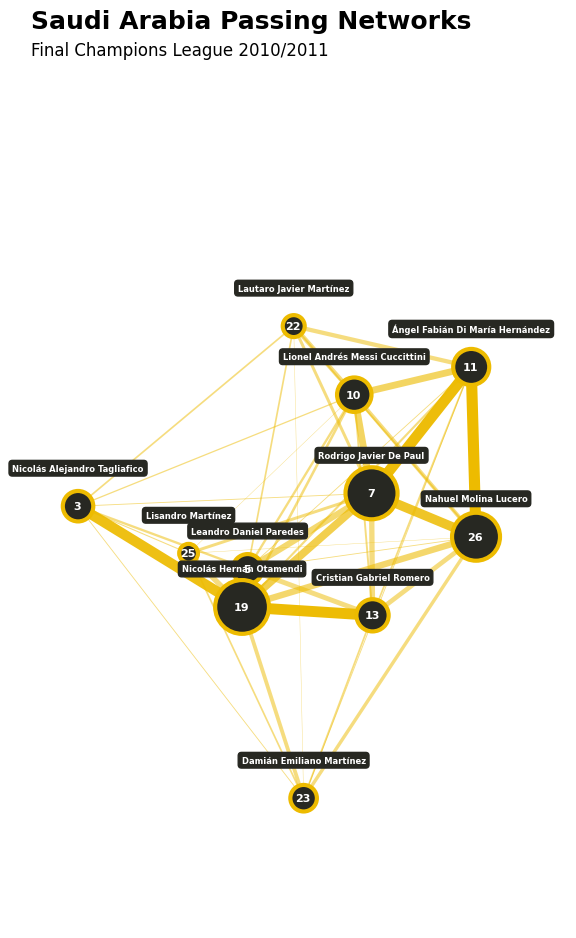

In [135]:
pitch = VerticalPitch(pitch_type='statsbomb', line_color='white',linewidth=1,goal_type='box')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Plot vertices
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='#272822', edgecolors='#EDBB00', linewidth=3, alpha=1, ax=ax["pitch"], zorder = 3)

#Add Players Name and Jersey Numbers
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x +6, row.y), c='white', va='center',
                   ha='center', size=6, weight = "bold", ax=ax["pitch"], zorder = 4, 
                   bbox=dict(facecolor='#272822', alpha=1, edgecolor='#272822', boxstyle='round,pad=0.4'))
    
for i, row in scatter_df.iterrows():
    pitch.annotate(row.jersey_number, xy=(row.x, row.y-0.1), c='white', va='center',
                   ha='center', size=8, weight = "bold", ax=ax["pitch"], zorder = 4)

#Plot edges
for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #take the average location of players to plot a line between them
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        #adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df['pass_count'].max() * 8)
        # adjust the alpha of the lines based on number of passes and set minimum alpha for a fewer pass
        alpha = max(num_passes / lines_df['pass_count'].max(), 0.2)
        alpha = max(alpha, 0.5)
        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=alpha, lw=line_width, zorder=2, color="#EDBB00", ax = ax["pitch"])

fig.text(s=hteam + " "+ "Passing Networks", x= 0.06, y= 1, fontsize=18,fontweight="bold")
fig.text(s='Final Champions League 2010/2011', x = 0.06, y=0.97, fontsize=12)
plt.show()